# Random jupyter notebook to explore/understand varius stuff

In [1]:
from initParam import *

## FIALA Tire Model

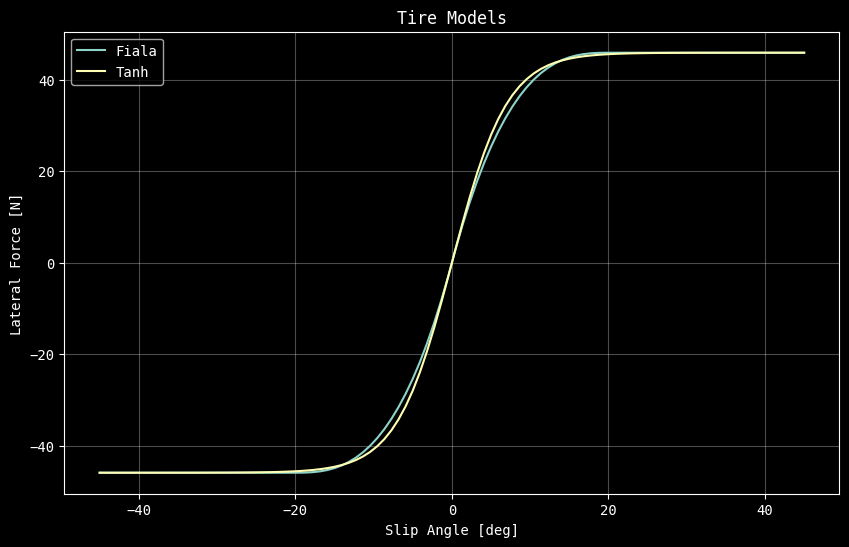

In [2]:
μf, μr = 0.5, 0.47   # [] friction coefficients front and rear
Cyf = 370.36;  # [N/rad] Cornering stiffness front tyre
Cyr = 1134.05; # [N/rad] Cornering stiffness rear tyre

def fiala(α, Fx, Fz, μ, Cy):
    assert Fx**2 <= μ**2 * Fz**2, "Longitudinal force exceeds maximum limit"
    Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
    αs = atan(3*Fy_max/Cy) # maximum slip angle
    assert αs > 0, "Maximum slip angle must be positive"
    if abs(α) < αs: 
        # return -Cy * tan(α) + Cy**2 * abs(tan(α)) * tan(α) / (3 * Fy_max) \
        #         - Cy**3 * tan(α)**3 / (27 * Fy_max**2)
        return Cy * tan(α) - Cy**2 * abs(tan(α)) * tan(α) / (3 * Fy_max) \
                + Cy**3 * tan(α)**3 / (27 * Fy_max**2)
    # else: return -Fy_max * sign(α)
    else: return Fy_max * sign(α)

# Test the fiala function
FX = 4 # [N] # longitudinal force
v_α = np.linspace(-π/4, π/4, 100) # slip angle vector
Fy_fiala = np.array([fiala(α, FX, Fz_Front, μf, Cyf) for α in v_α]) 

# tanh approximation
def fiala_tanh(α, Fx, Fz, μ, Cy):
    assert Fx**2 <= μ**2 * Fz**2, "Longitudinal force exceeds maximum limit"
    Fy_max = sqrt(μ**2 * Fz**2 - Fx**2) # maximum lateral force
    αs = atan(Fy_max/Cy) # maximum slip angle
    return Fy_max * np.tanh(α / αs) # tanh approximation

# Test the fiala_tanh function
Fy_fiala_tanh = np.array([fiala_tanh(α, FX, Fz_Front, μf, Cyf) for α in v_α])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(np.rad2deg(v_α), Fy_fiala, label='Fiala')
plt.plot(np.rad2deg(v_α), Fy_fiala_tanh, label='Tanh')
plt.title('Tire Models')
plt.xlabel('Slip Angle [deg]')
plt.ylabel('Lateral Force [N]')
plt.legend()
plt.show()

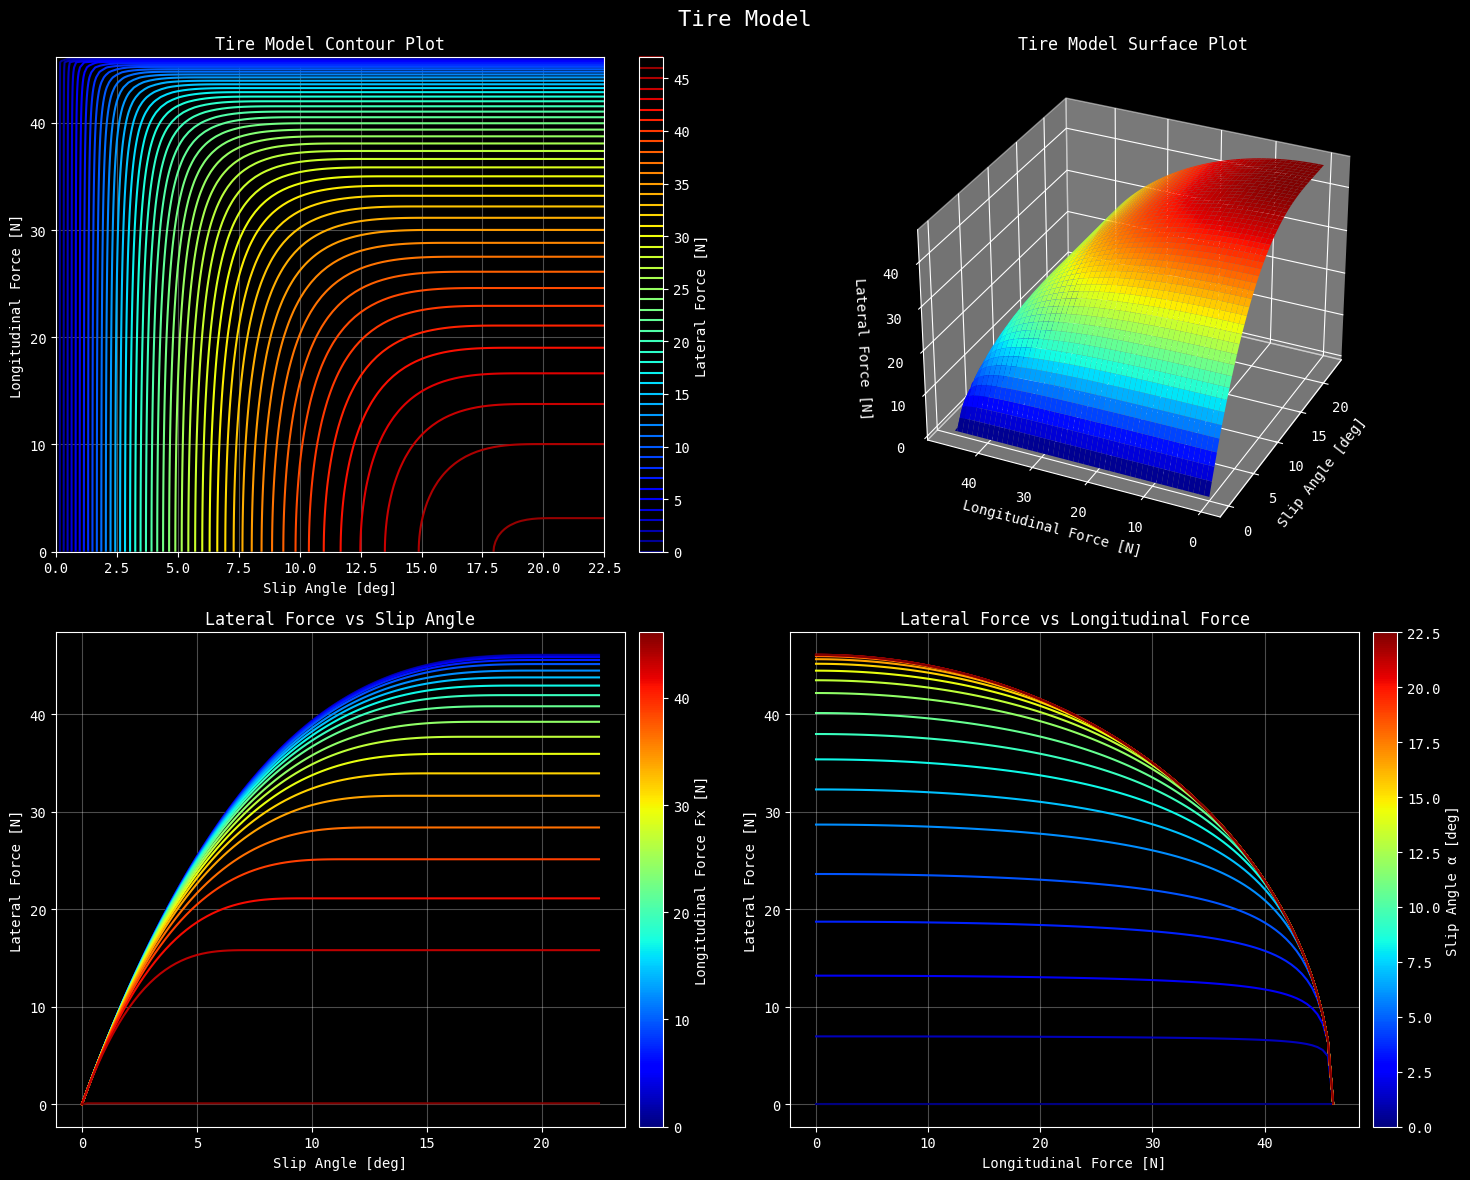

In [3]:
# show 3d plot of tire model, alpha on x-axis, Fx on y-axis, Fy on z-axis

tire = fiala
# tire = fiala_tanh

# let's to a contour plot first
α_min, α_max, α_n = np.deg2rad(0), π/8, 100 # [rad]
Fx_min, Fx_max, Fx_n = 0, μf*Fz_Front-0.0001, 100 # [N]
α_ = np.linspace(α_min, α_max, α_n) # slip angle vector
Fx_ = np.linspace(Fx_min, Fx_max, Fx_n) # longitudinal force vector

α_grid, Fx_grid = np.meshgrid(α_, Fx_) # create a grid of slip angles and longitudinal forces
grid = np.stack((α_grid, Fx_grid), axis=-1) # stack the grids to create a 2D grid of (α, Fx) pairs



# calculate the lateral force for each (α, Fx) pair
Fy_grid = np.array([[abs(tire(α, Fx, Fz_Front, μf, Cyf)) for α, Fx in grid.reshape(-1, 2)]]).reshape(α_n, Fx_n) 

# plot the contour plot
CM = 'jet' #'inferno'
fig = plt.figure(figsize=(15, 12))
plt.subplot(2,2,1)
# plt.contourf(np.rad2deg(α_grid), Fx_grid, Fy_grid, levels=50, cmap=CM)
plt.contour(np.rad2deg(α_grid), Fx_grid, Fy_grid, levels=50, cmap=CM)
plt.colorbar(label='Lateral Force [N]')
plt.title('Tire Model Contour Plot')
plt.xlabel('Slip Angle [deg]')
plt.ylabel('Longitudinal Force [N]')

# 3D surface plot of the tire model
# fig = plt.figure(figsize=(10, 10))
plt.subplot(2,2,2, projection='3d')
# ax = fig.add_subplot(111, projection='3d')
ax = plt.gca()
ax.plot_surface(np.rad2deg(α_grid), Fx_grid, Fy_grid, cmap=CM, edgecolor='none')
ax.set_title('Tire Model Surface Plot')
ax.set_xlabel('Slip Angle [deg]')
ax.set_ylabel('Longitudinal Force [N]')
ax.set_zlabel('Lateral Force [N]')
ax.view_init(elev=None, azim=205)
# plt.show()

# 2 2D subplots, first has alpha on x-axis, Fy on y-axis, Fx are different lines, second has Fx on x-axis, Fy on y-axis, alpha are different lines

# Get colormap and colors for lines
from matplotlib import colormaps
n_lines = 20 # number of lines to plot
colors = colormaps[CM](np.linspace(0, 1, n_lines))

# First subplot: alpha on x-axis, Fy on y-axis, Fx are different lines
plt.subplot(2, 2, 3)
indices = np.linspace(0, Fx_n - 1, n_lines, dtype=int)
for idx, i in enumerate(indices):
    plt.plot(np.rad2deg(α_), Fy_grid[i, :], label=f'Fx = {Fx_[i]:.1f} N', color=colors[idx])
plt.title('Lateral Force vs Slip Angle')
plt.xlabel('Slip Angle [deg]')
plt.ylabel('Lateral Force [N]')
# plt.legend()
sm = plt.cm.ScalarMappable(cmap=CM, norm=plt.Normalize(vmin=Fx_min, vmax=Fx_max))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.02)
cbar.set_label('Longitudinal Force Fx [N]')

# Second subplot: Fx on x-axis, Fy on y-axis, alpha are different lines
plt.subplot(2, 2, 4)
indices = np.linspace(0, α_n - 1, n_lines, dtype=int)
for idx, i in enumerate(indices):
    plt.plot(Fx_, Fy_grid[:, i], label=f'α = {np.rad2deg(α_[i]):.1f} deg', color=colors[idx])
plt.title('Lateral Force vs Longitudinal Force')
plt.xlabel('Longitudinal Force [N]')
plt.ylabel('Lateral Force [N]')
# plt.legend()
sm = plt.cm.ScalarMappable(cmap=CM, norm=plt.Normalize(vmin=np.rad2deg(α_min), vmax=np.rad2deg(α_max)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.02)
cbar.set_label('Slip Angle α [deg]')

plt.suptitle('Tire Model', fontsize=16)
plt.tight_layout()
plt.show()

# Drift Equilibrium

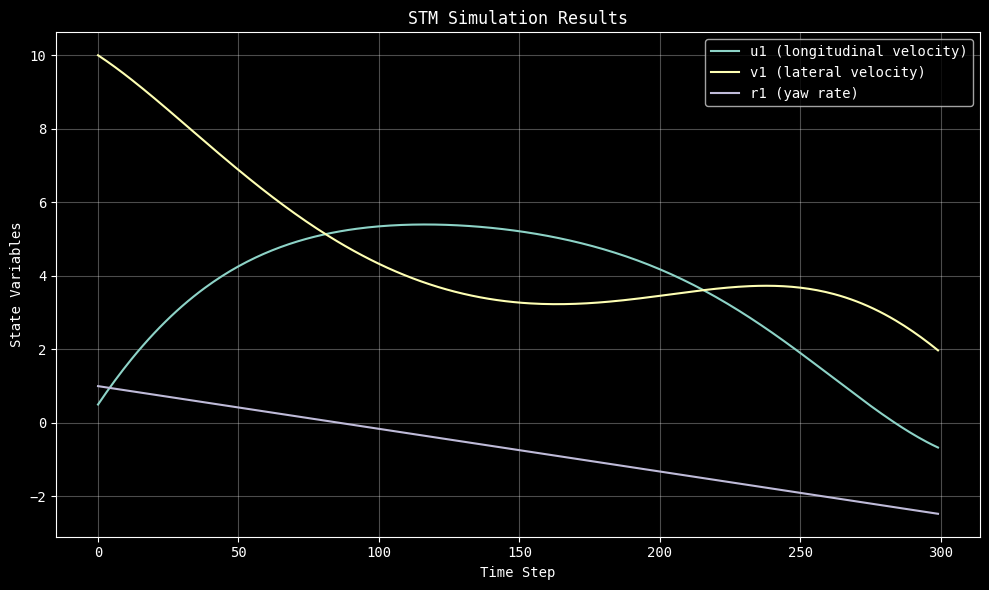

In [4]:
# equation of motion for the Single Track Model (power to rear only)
tire = fiala # use fiala tire model
# tire = fiala_tanh # use fiala tanh approx tire model

def d_uvr(uvr, δ, Fx): 
    u, v, r = uvr # unpack the state vector
    αf = δ - arctan2(v + a*r, u) # slip angle front
    αr = -arctan2(v - b*r, u) # slip angle rear
    Fyf = tire(αf, 0.0, Fz_Front, μf, Cyf) # lateral force front
    Fyr = tire(αr, Fx, Fz_Rear, μr, Cyr) # lateral force rear
    Fxr = Fx # rear longitudinal force
    return np.array([ # equations of motion
        (Fxr - Fyf * sin(δ)) / m + r * v,
        (Fyf * cos(δ) + Fyr) / m - r * u,
        (a * Fyf * cos(δ) - b * Fyr) / J_CoG
    ])

def stm_rk4(uvr, δ, Fx, dt=1): # runge-kutta 4th order method
    k1 = d_uvr(uvr, δ, Fx) * dt
    k2 = d_uvr(uvr + k1/2, δ, Fx) * dt
    k3 = d_uvr(uvr + k2/2, δ, Fx) * dt
    k4 = d_uvr(uvr + k3, δ, Fx) * dt
    return uvr + (k1 + 2*k2 + 2*k3 + k4) / 6 # update the state vector

def stm_euler(uvr, δ, Fx, dt=1): # euler method
    return uvr + d_uvr(uvr, δ, Fx) * dt # update the state vector

# simulate the STM for x seconds
T = 3 # [s] total simulation time
DT = 0.001 # [s] time step for the simulation

u0, v0, r0 = .5, 10.0, 1.0 # initial conditions
constant_force = 9.0 # [N] constant rear longitudinal force
constant_steer = np.deg2rad(15) # [deg] constant steering angle

n_steps = int(T / DT) # number of steps in the simulation
# initialize the state vector
state = np.zeros((n_steps, 3)) # [u, v, r]
state[0] = np.array([u0, v0, r0]) # initial conditions
# initialize the control input vector
control = np.zeros((n_steps, 2)) # [Fx, δ]
control[:, 0] = 2*constant_force # constant rear longitudinal force
control[:, 1] = steering_ratio_f*constant_steer # constant steering angle
# run the simulation
for i in range(1, n_steps):
    state[i] = stm_rk4(state[i-1], control[i, 1], control[i, 0], DT)  
    # state[i] = stm_euler(state[i-1], control[i, 1], control[i, 0], DT)  

# plot first n steps of the simulation  
dec = 10 # decimation factor
u1,v1,r1 = state[:,0], state[:,1], state[:,2] # unpack the state vector
k = 5
u1, v1, r1 = u1[::dec], v1[::dec], r1[::dec]
plt.figure(figsize=(10, 6))
plt.plot(u1, label='u1 (longitudinal velocity)')
plt.plot(v1, label='v1 (lateral velocity)')
plt.plot(r1, label='r1 (yaw rate)')
plt.title('STM Simulation Results')
plt.xlabel('Time Step')
plt.ylabel('State Variables')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# calculate the gradient of the state vector on a 3d grid
FX = 0 # [N] longitudinal force
# DELTA = np.deg2rad(15) # [rad] steering angle
DELTA = np.deg2rad(15) # [rad] steering angle

us = np.linspace(5, 15, 100) # longitudinal velocity
vs = np.linspace(-10, 10, 100) # lateral velocity
rs = np.linspace(-2, 2, 100) # yaw rate

duvr = np.zeros((len(us), len(vs), len(rs), 3)) # gradient of the state vector
for i, u in enumerate(tqdm(us)):
    for j, v in enumerate(vs):
        for k, r in enumerate(rs):
            duvr[i, j, k] = d_uvr(np.array([u, v, r]), DELTA, FX)

norm_duvr = np.linalg.norm(duvr, axis=-1) # calculate the norm of the gradient
min_norm, max_norm = norm_duvr.min(), norm_duvr.max()
print(f'Max: {max_norm:.2f}, Min: {min_norm:.2f}')

100%|██████████| 100/100 [00:10<00:00,  9.89it/s]

Max: 40.35, Min: 0.75


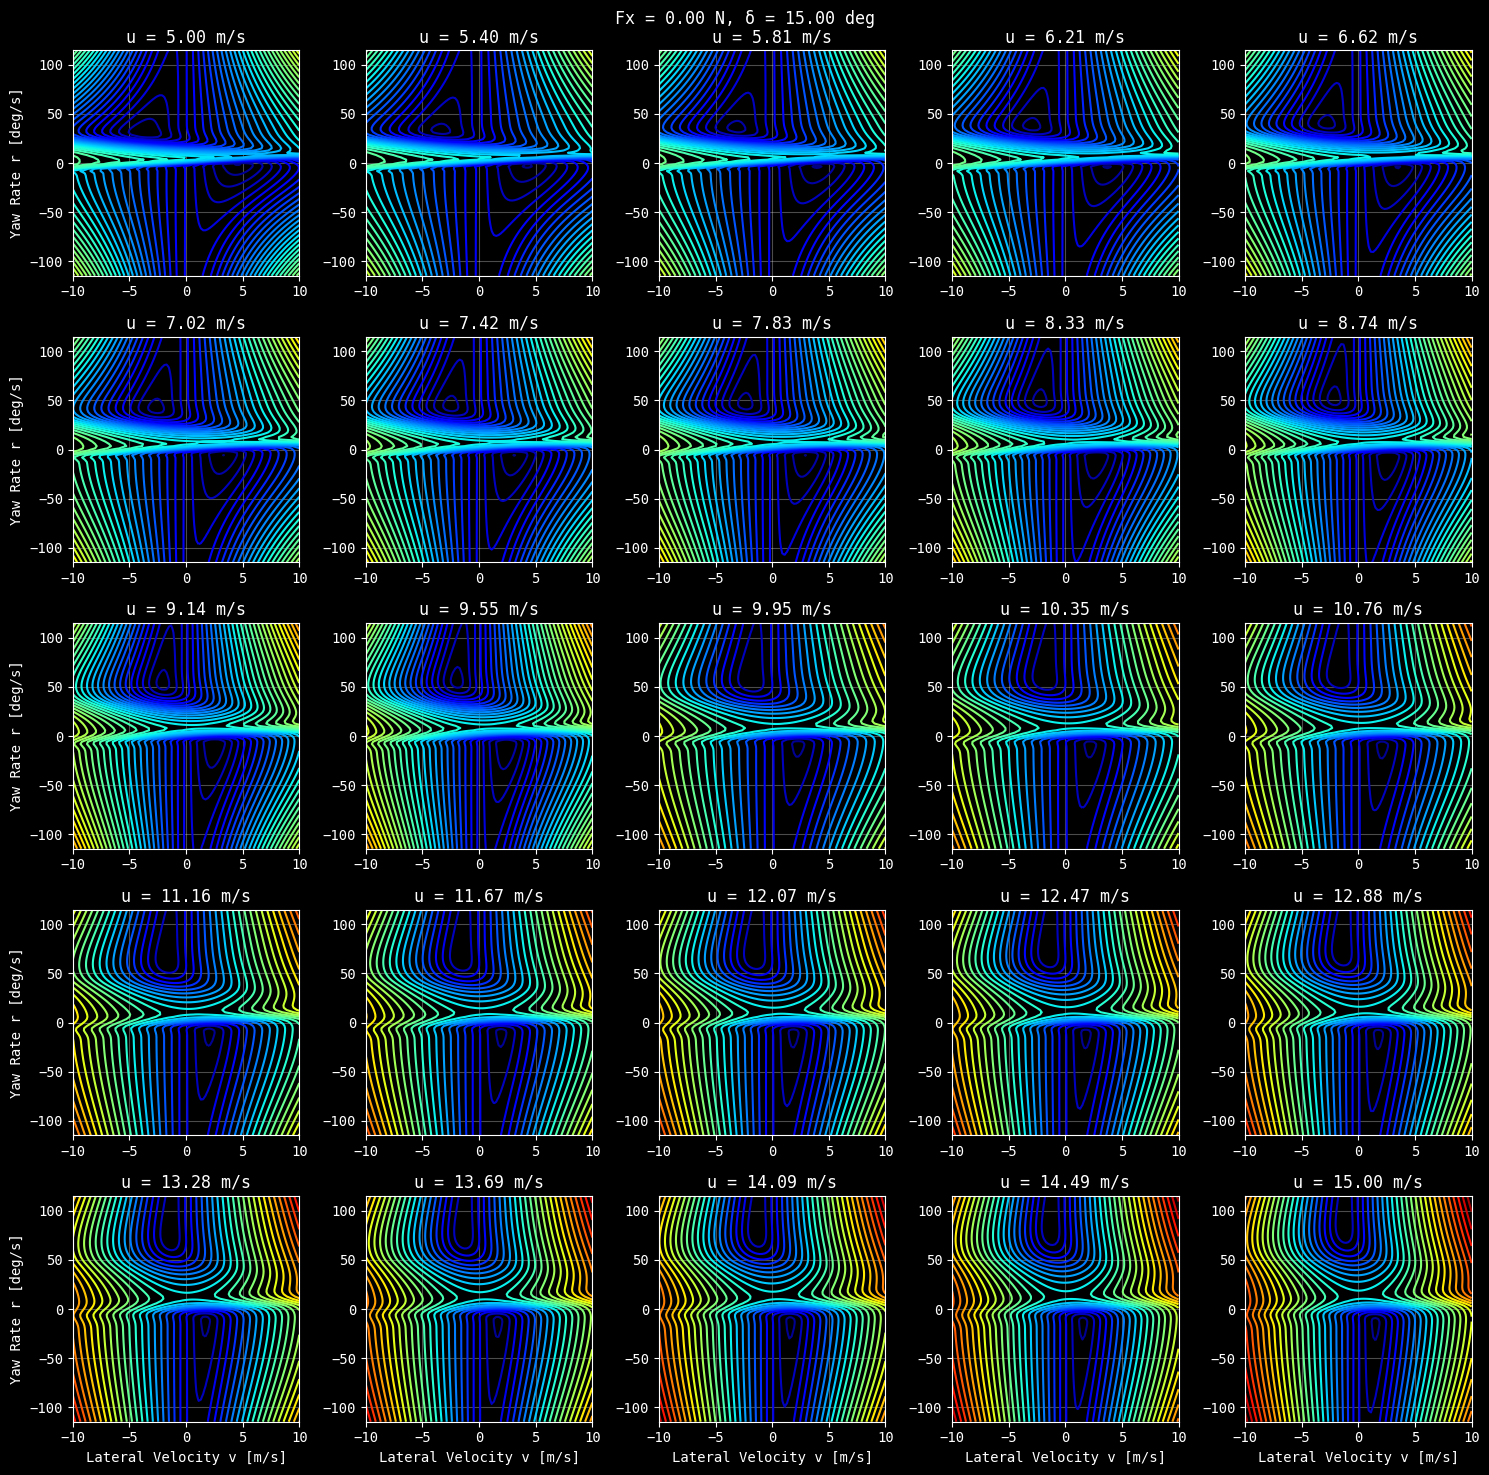

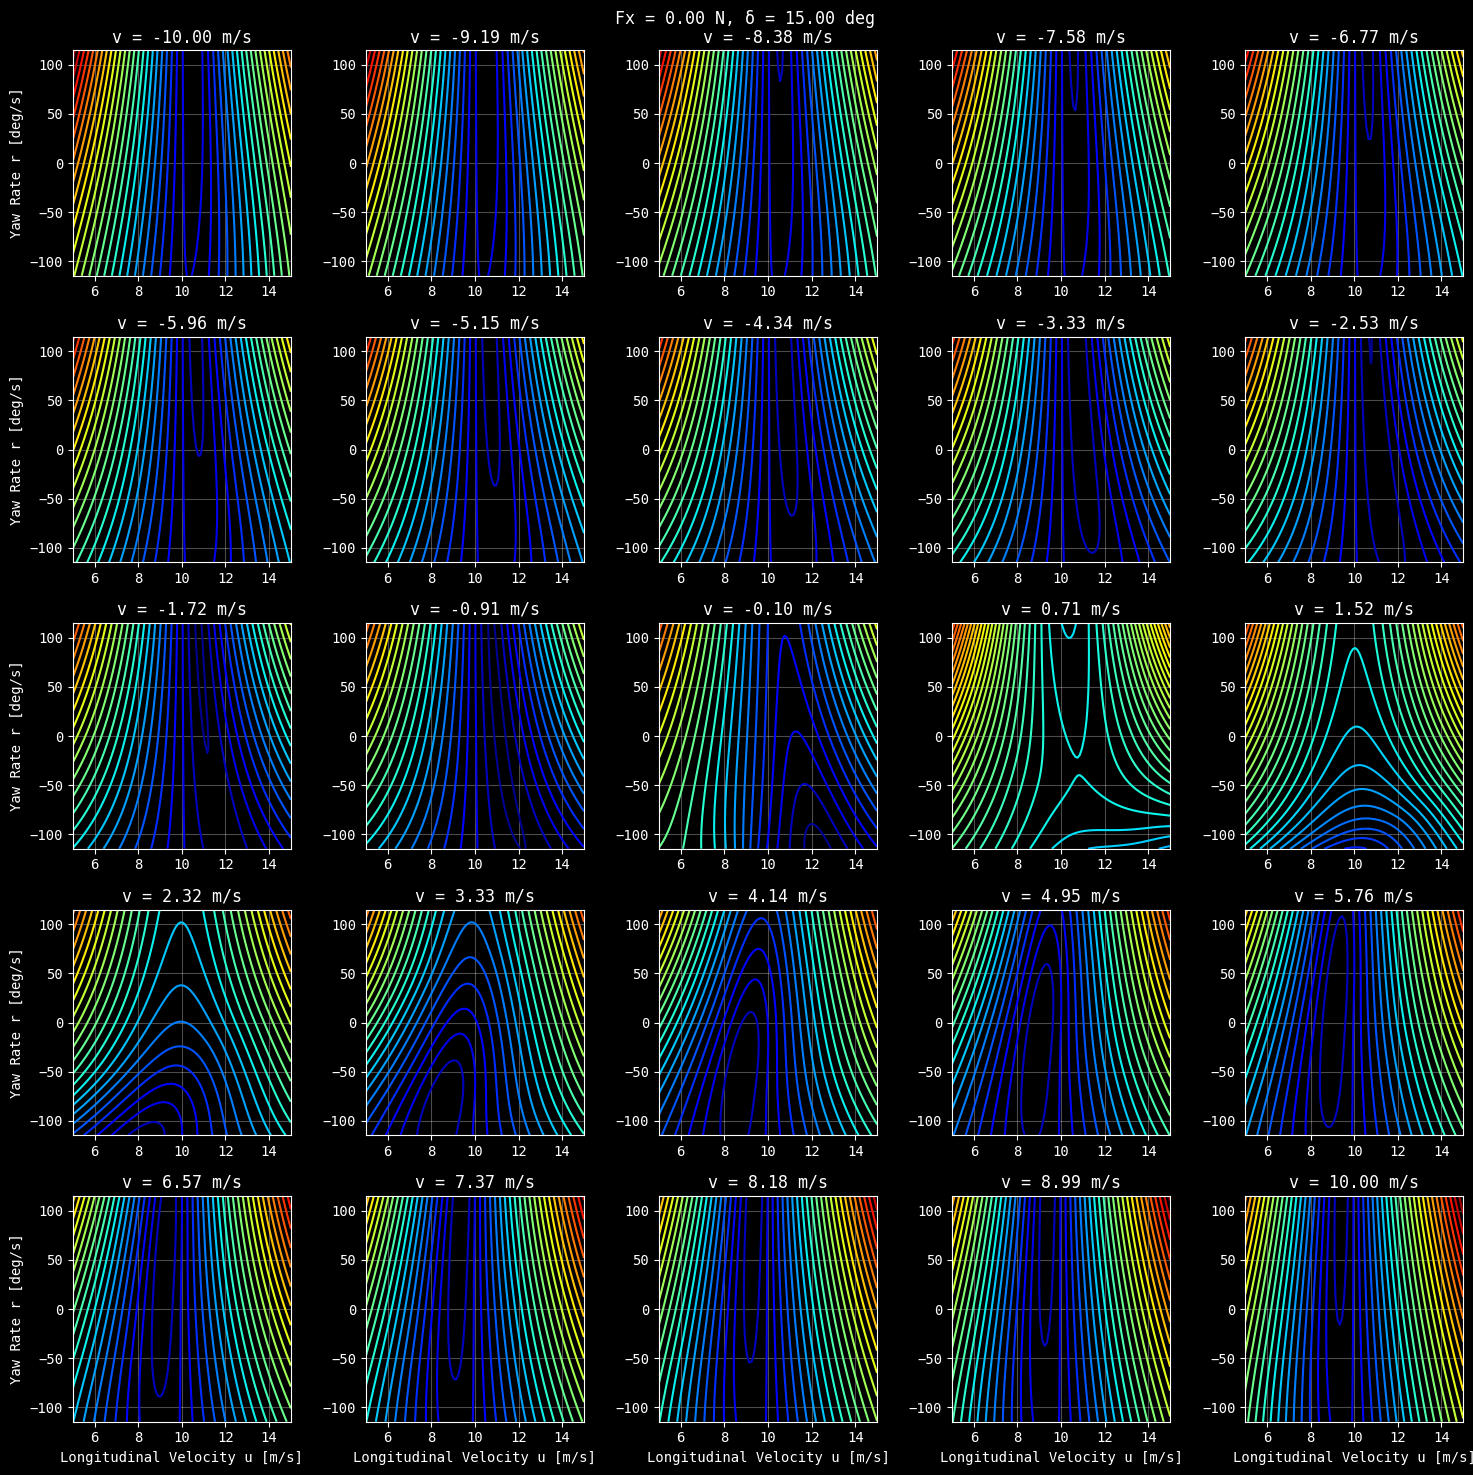

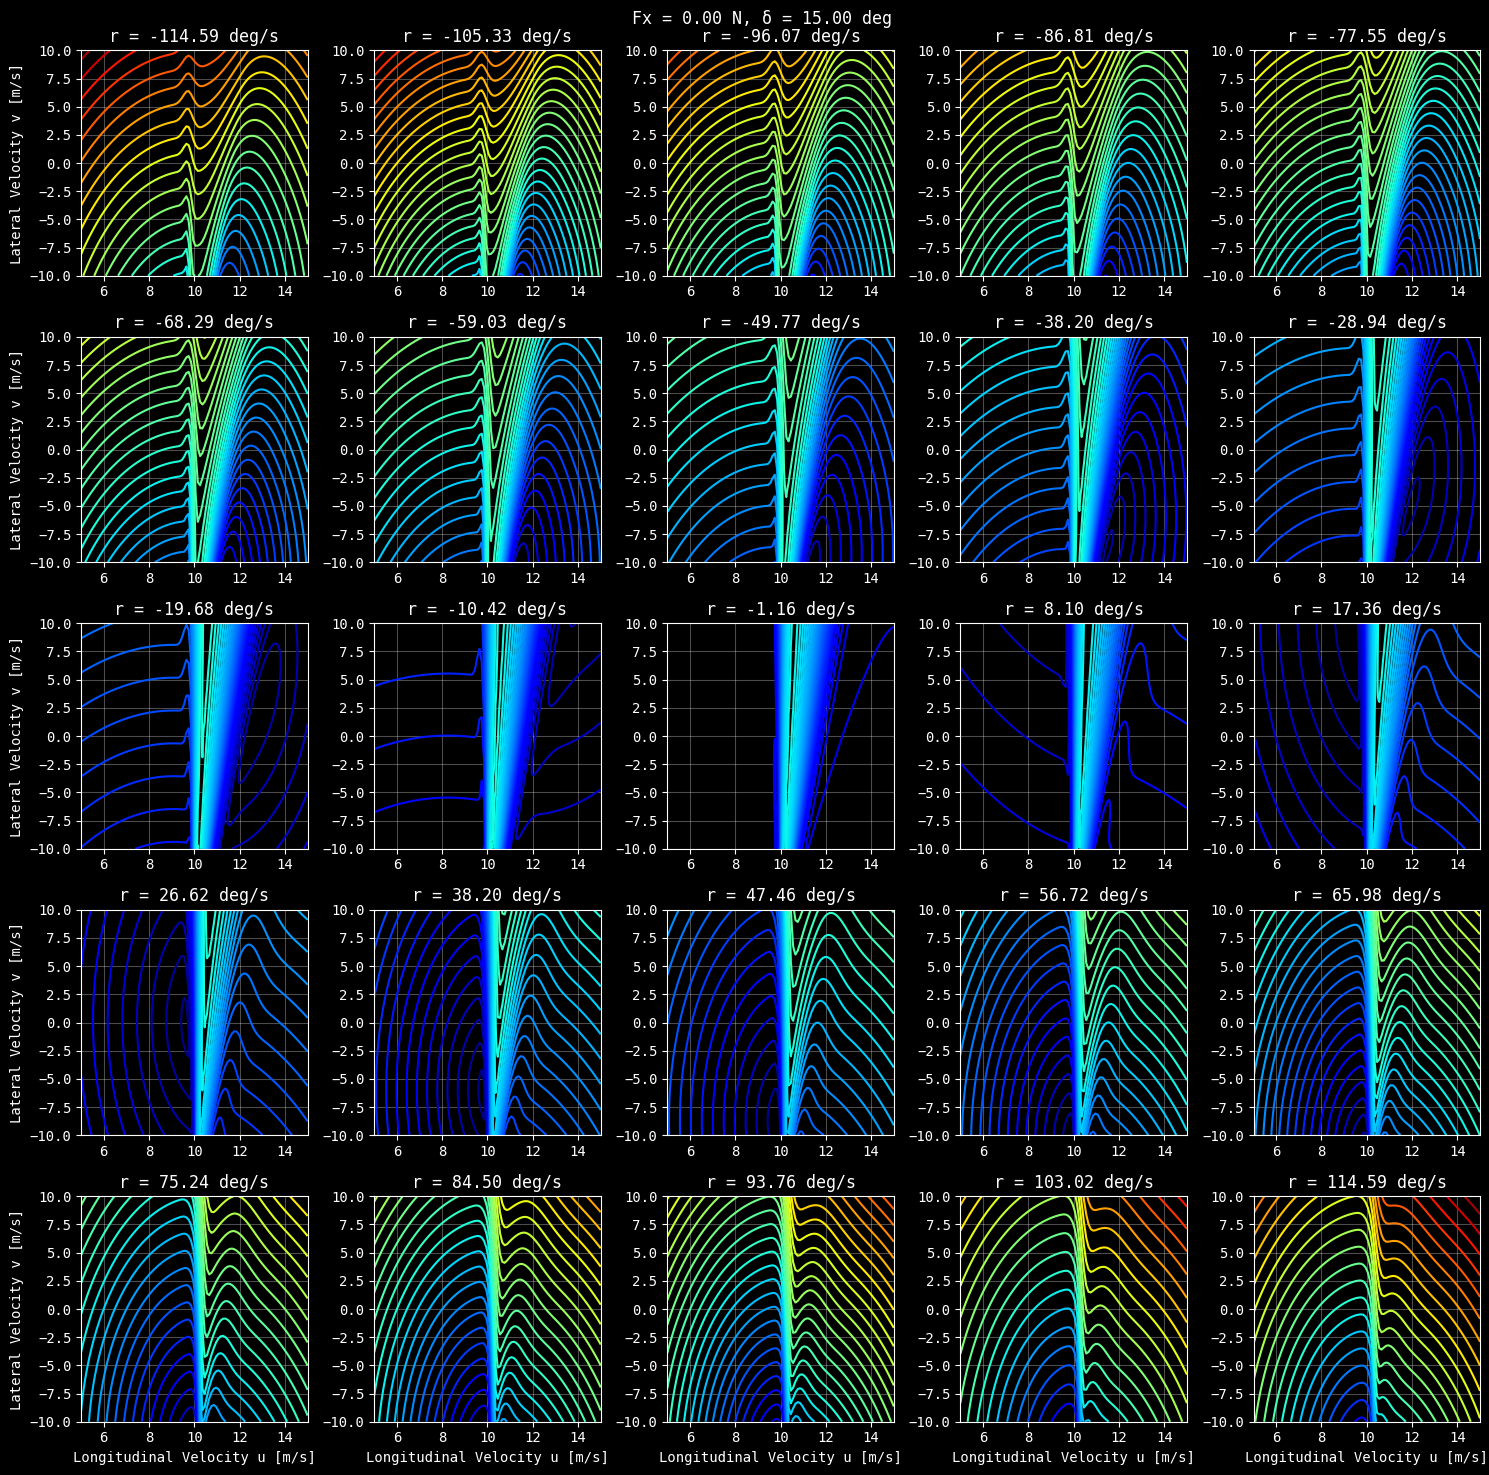

In [6]:
# plot slices of the gradient
LEV = 30
# 1 - slicing over u
idxs = np.linspace(0, len(us) - 1, 25, dtype=int)
plt.figure(figsize=(15, 15))
for ip, i in enumerate(idxs): # plot every 10th slice
    plt.subplot(5, 5, ip+1)
    # plot contour of norm_duvr with fixed min/max values
    contour = plt.contour(vs, np.rad2deg(rs), norm_duvr[i, :, :], levels=LEV, vmin=min_norm, vmax=max_norm, cmap=CM)
    plt.title(f'u = {us[i]:.2f} m/s')
    # plt.colorbar(contour)
    if ip>=20: plt.xlabel('Lateral Velocity v [m/s]')
    if ip%5 == 0: plt.ylabel('Yaw Rate r [deg/s]')
plt.suptitle(f'Fx = {FX:.2f} N, δ = {np.rad2deg(DELTA):.2f} deg')
plt.tight_layout()
plt.show()

# 2 - slicing over v
idxs = np.linspace(0, len(vs) - 1, 25, dtype=int)
plt.figure(figsize=(15, 15))
for ip, i in enumerate(idxs): # plot every 10th slice
    plt.subplot(5, 5, ip+1)
    # plot contour of norm_duvr with fixed min/max values
    contour = plt.contour(us, np.rad2deg(rs), norm_duvr[:, i, :], levels=LEV, vmin=min_norm, vmax=max_norm, cmap=CM)
    plt.title(f'v = {vs[i]:.2f} m/s')
    # plt.colorbar(contour)
    if ip>=20: plt.xlabel('Longitudinal Velocity u [m/s]')
    if ip%5 == 0: plt.ylabel('Yaw Rate r [deg/s]')
plt.suptitle(f'Fx = {FX:.2f} N, δ = {np.rad2deg(DELTA):.2f} deg')
plt.tight_layout()
plt.show()  
# 3 - slicing over r
idxs = np.linspace(0, len(rs) - 1, 25, dtype=int)
plt.figure(figsize=(15, 15))
for ip, i in enumerate(idxs): # plot every 10th slice
    plt.subplot(5, 5, ip+1)
    # plot contour of norm_duvr with fixed min/max values
    contour = plt.contour(us, vs, norm_duvr[:, :, i], levels=LEV, vmin=min_norm, vmax=max_norm, cmap=CM)
    plt.title(f'r = {np.rad2deg(rs[i]):.2f} deg/s')
    # plt.colorbar(contour)
    if ip>=20: plt.xlabel('Longitudinal Velocity u [m/s]')
    if ip%5 == 0: plt.ylabel('Lateral Velocity v [m/s]')
plt.suptitle(f'Fx = {FX:.2f} N, δ = {np.rad2deg(DELTA):.2f} deg')
plt.tight_layout()
plt.show()